## Прогнозирование сердечных заболеваний 

Целью проекта является прогнозирование сердечных заболеваний     
На основе имеющихся данных требуется спрогнозировать риск сердечной недостаточности     
В проекте будет применятся StackingClassifier     

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import StackingClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV 

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-darkgrid')

## Загрузка данных и первичный анализ 

In [3]:
df_train = pd.read_csv('./train.csv') #тренировочные данные
df_test = pd.read_csv('./test.csv') #тестовые данные
submission = pd.read_csv('./sample_submission.csv') #формат ответов

In [4]:
df_train.info() #вывожу основную информацию по тренировочным данным 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   age          30000 non-null  int64  
 2   gender       30000 non-null  int64  
 3   height       30000 non-null  int64  
 4   weight       30000 non-null  float64
 5   ap_hi        30000 non-null  int64  
 6   ap_lo        30000 non-null  int64  
 7   cholesterol  30000 non-null  int64  
 8   gluc         30000 non-null  int64  
 9   smoke        30000 non-null  int64  
 10  alco         30000 non-null  int64  
 11  active       30000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.7 MB


У нас имеется 70000 строк данных для тренировок.Так же пропущенных значений нет. И все колонки имеют числовой формат  
Колонка `cardio` это целевой признак    
В тестовом наборе данных у нас 30000 строк

In [6]:
df_train.head()  # посмотрим на сам датасет

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.00,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.00,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.00,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.00,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.00,100,60,1,1,0,0,0,0


In [7]:
len(df_train['id']) == df_train['id'].nunique() # проверка, что колонка id содержит только уникальные значения

True

In [8]:
for i in [df_train, df_test]:
    i.drop(columns = 'id', inplace = True)  #удаляем колонку id 

In [9]:
df_train.describe()  #посмотрим на распределение данных 

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00
mean,19468.87,1.35,164.36,74.21,128.82,96.63,1.37,1.23,0.09,0.05,0.80,0.50
std,2467.25,0.48,8.21,14.40,154.01,188.47,0.68,0.57,0.28,0.23,0.40,0.50
min,10798.00,1.00,55.00,10.00,-150.00,-70.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,17664.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.00,0.00
50%,19703.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.00,0.00
75%,21327.00,2.00,170.00,82.00,140.00,90.00,2.00,1.00,0.00,0.00,1.00,1.00
max,23713.00,2.00,250.00,200.00,16020.00,11000.00,3.00,3.00,1.00,1.00,1.00,1.00


В колонках как `height, weight, ap_hi, ap_lo` имеются аномально большие выбросы. Выходящие за грани разумного. Придётся обработать эти данные

In [10]:
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo'] #числовые признаки 
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'] #категориальные признаки\
target = ['cardio'] #целевой признак

In [11]:
df_test[num_cols].describe() #глянем на числовые данные в тестовом наборе данных 

,age,height,weight,ap_hi,ap_lo
count,30000.00,30000.00,30000.00,30000.00,30000.00
mean,19455.53,164.32,74.12,130.27,95.69
std,2477.84,8.21,14.34,212.50,163.85
min,8865.00,50.00,10.00,-130.00,-90.00
25%,17658.00,159.00,65.00,120.00,80.00
50%,19694.00,165.00,72.00,120.00,80.00
75%,21320.00,170.00,82.00,140.00,90.00
max,23705.00,198.00,183.00,16020.00,9100.00


В тестовом наборе данных так же имеется аномально высокие значения в артериальных давлениях    
Визуализируем числовые признаки 

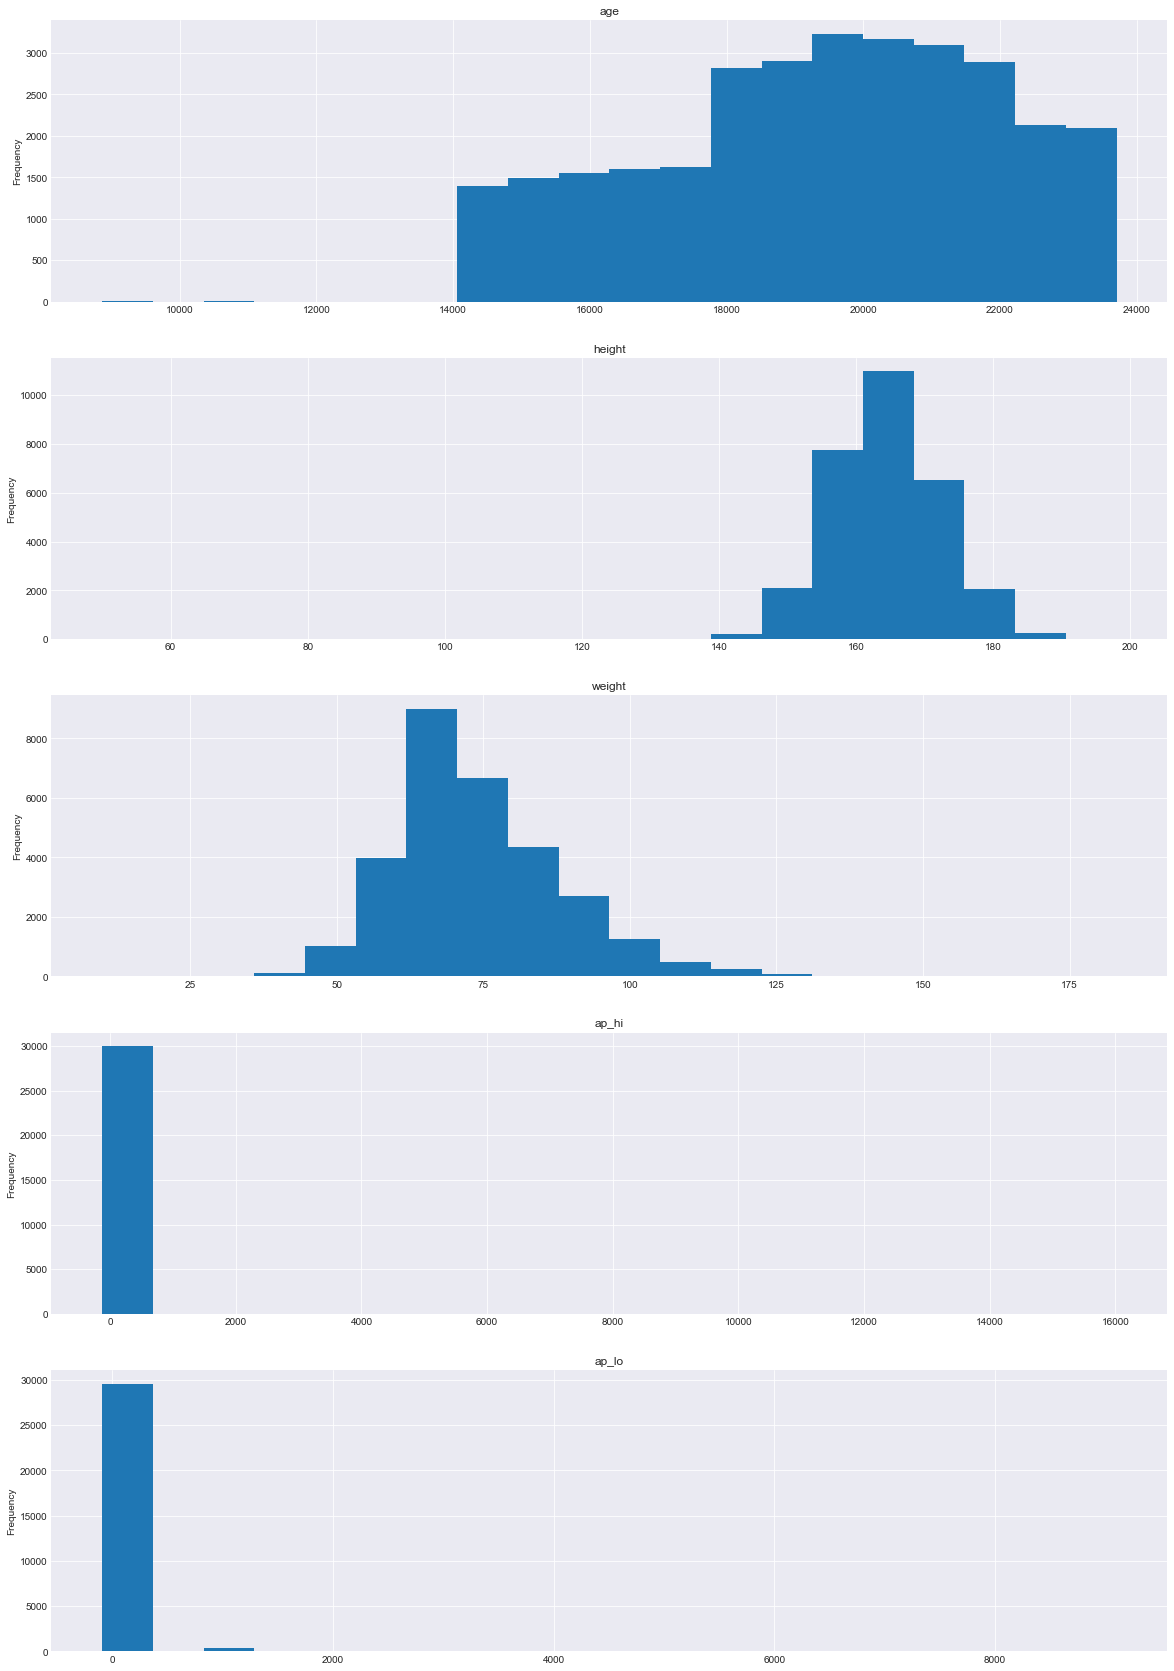

In [12]:
fig = plt.figure(figsize = (20,30))
for i in range(len(num_cols)):
    data = df_test[num_cols[i]]
    plt.subplot(5, 1, i+1)
    data.plot(kind = 'hist', bins = 20)
    plt.title(num_cols[i])

Делаем предположение 
`age` дан в днях. Максимальный возраст пациента равняется приблизительно 65 годам   
`height` дано в сантиметрах. Причём имеются выборсы в виде роста в 55см и роста в 250 см. Надо проверить эти значения   
`weight` имеется вес 10кг и максимальный в 200кг   
в `ap_hi` и `ap_lo` имеются очень сильные выбросы   

В тренировочных данных так же имеются очень сильные выбросы. Поскольку от них мы не можем избавиться, предлагаю все значения ниже 2 процентилей приравнять к нижней границе, а значения выше 98 процентилей приравнять к верхней границе

In [13]:
for x in [df_train, df_test]:  
    for i in num_cols:                     #прохоим по датасетам и числовым колонкам
        x_02 = x[i].quantile(0.01)
        x_98 = x[i].quantile(0.985)         #извлекаем 1 и 98.5 процентиль для каждой колонки 
        
        x.loc[x[i] < x_02, i] = x_02  
        x.loc[x[i] > x_98, i] = x_98       # приравниваем выбросы к данным процентилям

Теперь посмотрим на категориальные колонки 

In [14]:
df_train[cat_cols].nunique() #посмотрим количество категорий в каждой из колонк 

gender         2
cholesterol    3
gluc           3
smoke          2
alco           2
active         2
dtype: int64

только в колонке `cholesterol` имеются 3 категории. Посмотрим на распределение целевого признака.
Теперь хочу посмотреть на целевой признак, что бы понять надо ли придавать веса во время обучения

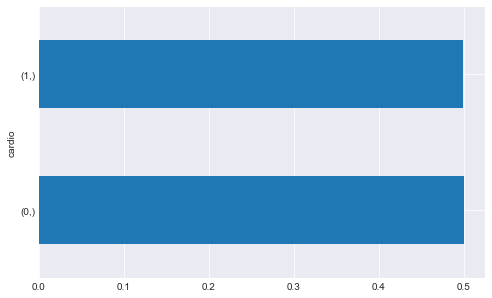

In [15]:
df_train[target].value_counts(normalize = True).plot(kind = 'barh', figsize = (8,5));

Целевой признак сбалансированный

Посмотрим на распределение категориальных величин в тестовой и тренировочной выборке 

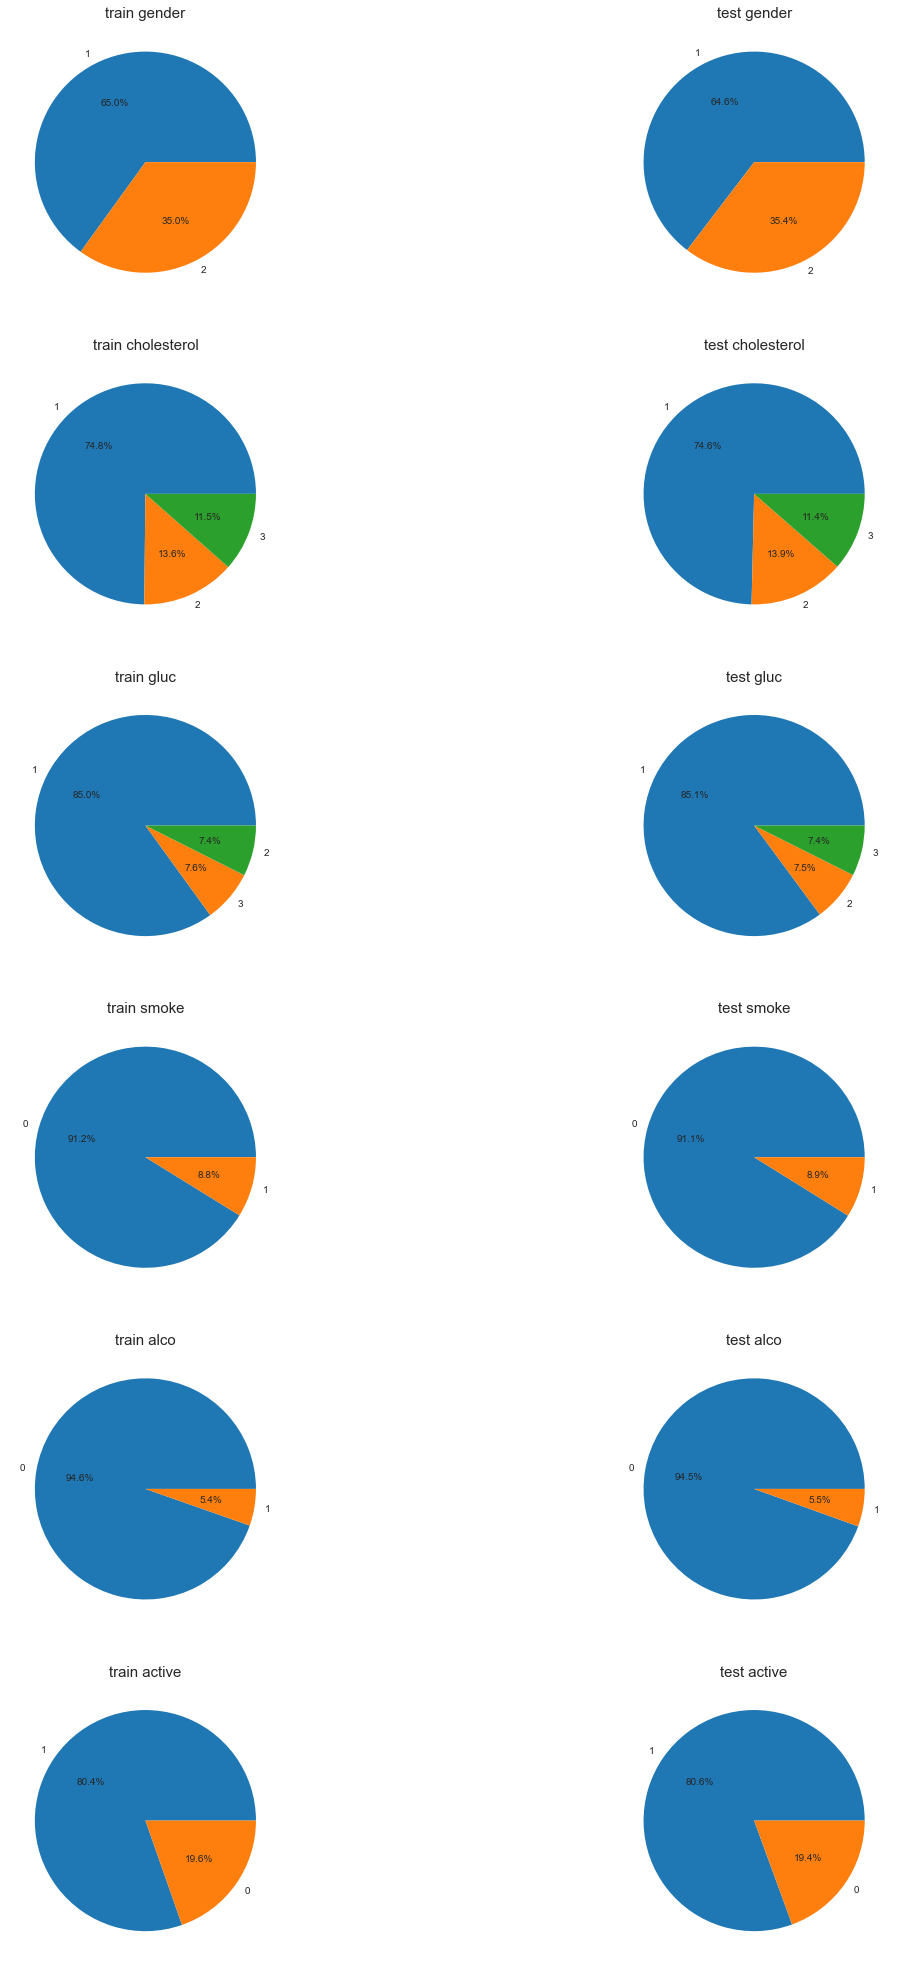

In [16]:
fig = plt.figure(figsize = (20, 60))
for i in range(len(cat_cols)):
    data1 = df_test[cat_cols[i]].value_counts()
    data2 = df_train[cat_cols[i]].value_counts()
    plt.subplot(10, 2, (i+1)*2)
    plt.pie(data1, autopct='%.1f%%', labels = data1.index, textprops={'fontsize': 10})
    plt.title('test ' + cat_cols[i], fontsize = 15)
    plt.subplot(10, 2, (i+1)*2-1)
    plt.pie(data2, autopct='%.1f%%', labels = data2.index, textprops={'fontsize': 10})
    plt.title('train ' + cat_cols[i], fontsize = 15)

Мы пронаблюдали, что распределение категориальных величин в тренировочной и тестовой выборке +- одинаковое

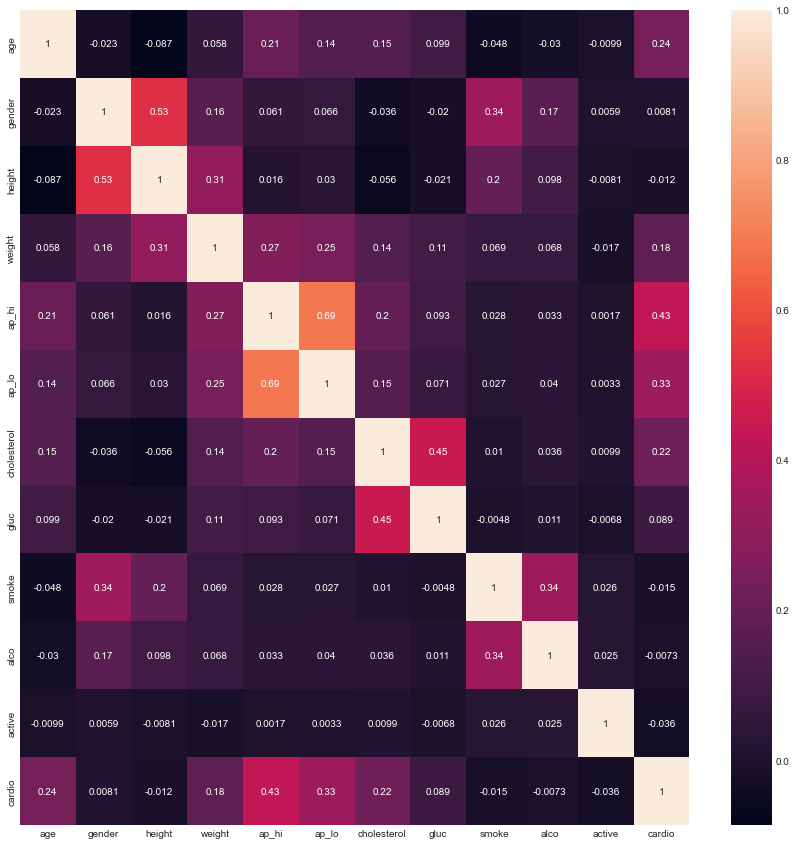

In [17]:
fig = plt.figure(figsize = (15, 15))  #посмотрим на корреляцию наших значений
sns.heatmap(df_train.corr(), annot = True)
plt.show()

**Вывод**

Данные предобработаны.  В наборе данных с целевым признаком лучше всего коррелирует `ap_hi` и `ap_lo`.   
Очень маленький процент людей относится к категории курящих/принимающих алкоголь.
Категория `active` хуже всего коррелирует с другими признаками  

## Предобработка данных перед обучением

Разбиваем датасеты на признаки и на целевой признак

In [18]:
features_train = df_train.drop(['cardio'], axis = 1) # признаки в тренировочном наборе данных
features_test = df_test #признаки в тестовом наборе 
target_train = df_train['cardio'] #целевой признак

Производим масштабирование 

In [19]:
scaler = StandardScaler()
scaler.fit(features_train[num_cols])
features_train[num_cols] = scaler.transform(features_train[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

Применяем технику ОНЕ

In [20]:
onehot_encoder = OneHotEncoder(sparse = False ,drop = 'first', dtype = 'int64') 

train_one = pd.DataFrame(onehot_encoder.fit_transform(features_train[cat_cols]))
test_one = pd.DataFrame(onehot_encoder.fit_transform(features_test[cat_cols]))

features_train.drop(columns = cat_cols, inplace = True)
features_test.drop(columns = cat_cols, inplace = True)

features_train = pd.concat([features_train, train_one], axis = 1)
features_test = pd.concat([features_test, test_one], axis = 1)

In [21]:
features_test = features_test.rename(columns = lambda x: str(x))
features_train = features_train.rename(columns = lambda x: str(x))

**Вывод** данные обработаны и готовы к обучению

## Проверка наиважнейших признаков

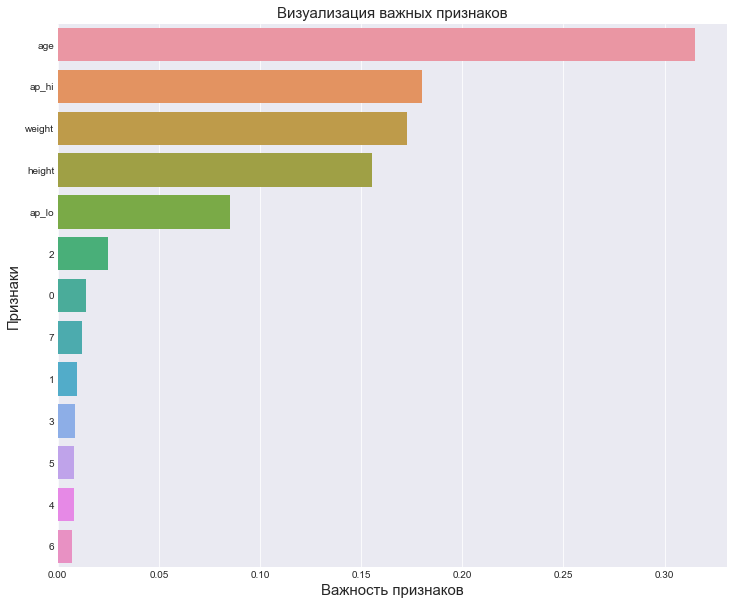

In [22]:
clf = RandomForestClassifier(n_estimators=100)  #создаю модель случайного леса 
clf.fit(features_train,target_train) #обучаю модель

#выделяю важнейшие признаки 
feature_imp = pd.Series(clf.feature_importances_,index=features_train.columns).sort_values(ascending=False) 

# создаю столбчатую диаграмму
fig = plt.figure(figsize = (12,10))
sns.barplot(x=feature_imp, y=feature_imp.index) 
plt.xlabel('Важность признаков', fontsize = 15)
plt.ylabel('Признаки', fontsize = 15)
plt.title('Визуализация важных признаков', fontsize = 15)
plt.show()

Информация о важности признаков в обучении может пригодиться исследователям. 

## Применение StackingClassifier

In [23]:
estimators  = [
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=10,random_state=12345)), 
    ('lr', LogisticRegression(solver = 'sag')),
    ('dtc', DecisionTreeClassifier(random_state=12345, max_depth=5)), 
    ('knc', KNeighborsClassifier(algorithm = 'ball_tree', n_neighbors = 7)), 
    ('bnb', BernoulliNB()),
    ('gbc', GradientBoostingClassifier(random_state = 12345,n_estimators=200))
]


clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv = 5)
clf.fit(features_train, target_train) # обучение модели 

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       n_estimators=400,
                                                       random_state=12345)),
                               ('lr', LogisticRegression(solver='sag')),
                               ('dtc',
                                DecisionTreeClassifier(max_depth=5,
                                                       random_state=12345)),
                               ('knc',
                                KNeighborsClassifier(algorithm='ball_tree',
                                                     n_neighbors=7)),
                               ('bnb', BernoulliNB()),
                               ('gbc',
                                GradientBoostingClassifier(n_estimators=200,
                                                           random_state=12345))],
                   fina

In [24]:
submission['cardio'] = pd.Series(clf.predict_proba(features_test)[:, 1])
submission.to_csv('./my_submissionstacking.csv', index=False) #сохранение предсказаний 